In [2]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ============================
# 1. Fetch Binance Data
# ============================
exchange = ccxt.binance()
symbol = "BTC/USDT"
timeframe = "1h"
limit = 1000  # number of candles

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
df = pd.DataFrame(ohlcv, columns=["timestamp","Open","High","Low","Close","Volume"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)

In [4]:
# ============================
# 2. Indicators
# ============================

# ---- RSI ----
def rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["RSI"] = rsi(df["Close"], 14)

# ---- MACD ----
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = ema12 - ema26
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["Hist"] = df["MACD"] - df["Signal"]

# ---- DEMA(9) ----
ema1 = df["Close"].ewm(span=9, adjust=False).mean()
ema2 = ema1.ewm(span=9, adjust=False).mean()
df["DEMA"] = 2 * ema1 - ema2
df["DEMA_Signal"] = np.where(df["Close"] < df["DEMA"], 1, -1)  # 1=uptrend, -1=downtrend

# ---- SMA(3) ----
df["SMA"] = df["Close"].rolling(3).mean()
df["SMA_Signal"] = np.where(df["Close"] < df["SMA"], 1, -1)

# ---- Trend Strength Index (TSI) ----
def tsi(series, r=25, s=13):
    diff = series.diff()
    abs_diff = diff.abs()
    double_smoothed_diff = diff.ewm(span=r, adjust=False).mean().ewm(span=s, adjust=False).mean()
    double_smoothed_abs = abs_diff.ewm(span=r, adjust=False).mean().ewm(span=s, adjust=False).mean()
    return 100 * (double_smoothed_diff / double_smoothed_abs)

df["TSI"] = tsi(df["Close"])

# ---- Stochastic ----
period = 14
smooth_k, smooth_d = 3, 3
low_min = df["Low"].rolling(period).min()
high_max = df["High"].rolling(period).max()
df["%K"] = 100 * (df["Close"] - low_min) / (high_max - low_min)
df["%K"] = df["%K"].rolling(smooth_k).mean()
df["%D"] = df["%K"].rolling(smooth_d).mean()

In [5]:
df.head(50)

,Open,High,Low,Close,Volume,RSI,MACD,Signal,Hist,DEMA,DEMA_Signal,SMA,SMA_Signal,TSI,%K,%D
timestamp,,,,,,,,,,,,,,,,
2025-08-15 20:00:00,116936.28,117323.47,116862.50,117280.00,248.37175,NaN,0.000000,0.000000,0.000000,117280.000000,-1,NaN,-1,NaN,NaN,NaN
2025-08-15 21:00:00,117280.01,117350.00,117000.00,117320.02,268.99006,NaN,3.192479,0.638496,2.553983,117294.407200,-1,NaN,-1,100.000000,NaN,NaN
2025-08-15 22:00:00,117320.01,117738.57,117302.65,117702.00,374.66043,NaN,36.128666,7.736530,28.392136,117442.165120,-1,117434.006667,-1,100.000000,NaN,NaN
2025-08-15 23:00:00,117701.99,117761.88,117036.53,117342.05,462.67467,NaN,32.807688,12.750761,20.056927,117417.541584,1,117454.690000,1,84.249036,NaN,NaN
2025-08-16 00:00:00,117342.04,117781.99,117231.14,117735.21,546.22017,NaN,61.195097,22.439628,38.755468,117540.300458,-1,117593.086667,-1,76.168519,NaN,NaN
2025-08-16 01:00:00,117735.20,117898.99,117626.31,117821.60,349.62497,NaN,89.630074,35.877717,53.752356,117657.762918,-1,117632.953333,-1,71.674148,NaN,NaN
2025-08-16 02:00:00,117821.61,117821.61,117440.74,117505.51,307.50607,NaN,85.671608,45.836495,39.835112,117625.699977,1,117687.440000,1,60.913801,NaN,NaN
2025-08-16 03:00:00,117505.52,117657.97,117389.56,117429.63,217.17429,NaN,75.540825,51.777361,23.763464,117573.055295,1,117585.580000,1,52.351740,NaN,NaN
2025-08-16 04:00:00,117429.63,117884.00,117419.44,117815.66,222.51215,NaN,97.537154,60.929320,36.607834,117672.596487,-1,117583.600000,-1,48.971445,NaN,NaN


In [10]:
# ============================
# 3. Labels (Swing Highs/Lows)
# ============================
lookback = 5

def detect_swings(highs, lows, lb=5):
    labels = np.zeros(len(highs))
    for i in range(lb, len(highs) - lb):
        if highs[i] == max(highs[i-lb:i+lb+1]):
            labels[i] = -1  # swing high = downtrend reversal
        elif lows[i] == min(lows[i-lb:i+lb+1]):
            labels[i] = 1   # swing low = uptrend reversal
    return labels

df["Label"] = detect_swings(df["High"].values, df["Low"].values, lookback)


In [11]:
df.dropna(inplace=True)

In [12]:
# ============================
# 4. Save CSV
# ============================
csv_path = "btc_master_indicators.csv"
df.to_csv(csv_path)
print(f"✅ Saved {csv_path}")

✅ Saved btc_master_indicators.csv


In [13]:
df.head()

,Open,High,Low,Close,Volume,RSI,MACD,Signal,Hist,DEMA,DEMA_Signal,SMA,SMA_Signal,TSI,%K,%D,Label
timestamp,,,,,,,,,,,,,,,,,
2025-08-16 13:00:00,117747.35,117799.99,117582.29,117623.52,365.37584,55.004356,56.021414,56.616744,-0.595330,117574.163910,-1,117583.133333,-1,18.613904,61.862046,52.999706,0.0
2025-08-16 14:00:00,117623.53,117771.40,117550.00,117771.39,253.05868,50.704725,71.073613,59.508118,11.565495,117650.245360,-1,117714.090000,-1,18.906792,76.344282,64.427809,0.0
2025-08-16 15:00:00,117771.40,117825.00,117621.10,117676.70,224.96201,47.186692,74.503073,62.507109,11.995964,117669.694874,-1,117690.536667,1,18.261580,72.867065,70.357798,-1.0
2025-08-16 16:00:00,117676.70,117817.65,117676.70,117747.65,389.81984,55.195870,82.000762,66.405840,15.594923,117707.964767,-1,117731.913333,-1,18.205124,78.887209,76.032852,0.0
2025-08-16 17:00:00,117747.64,117747.65,117651.72,117693.00,181.46105,55.703390,82.580995,69.640871,12.940124,117714.370909,1,117705.783333,1,17.660871,75.917318,75.890531,0.0


In [8]:
# ============================
# 5. Visualization Function
# ============================
def plot_indicator(df, col, title):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df[col], label=col, color="blue")

    plt.scatter(df.index[df["Label"]==1], df[col][df["Label"]==1],
                marker="^", color="green", s=100, label="Swing Low (Up Reversal)")
    plt.scatter(df.index[df["Label"]==-1], df[col][df["Label"]==-1],
                marker="v", color="red", s=100, label="Swing High (Down Reversal)")

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

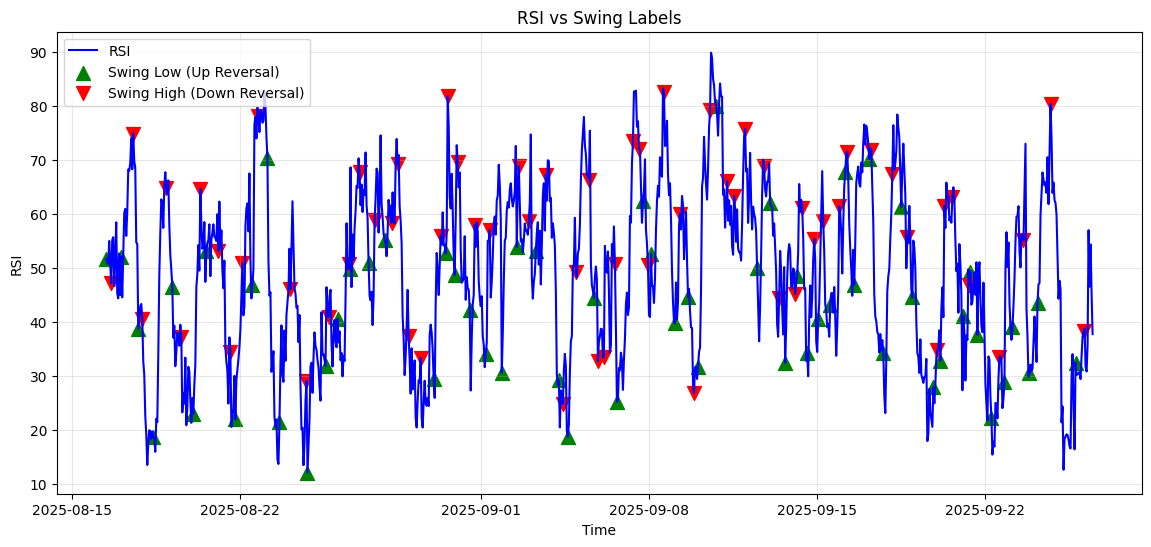

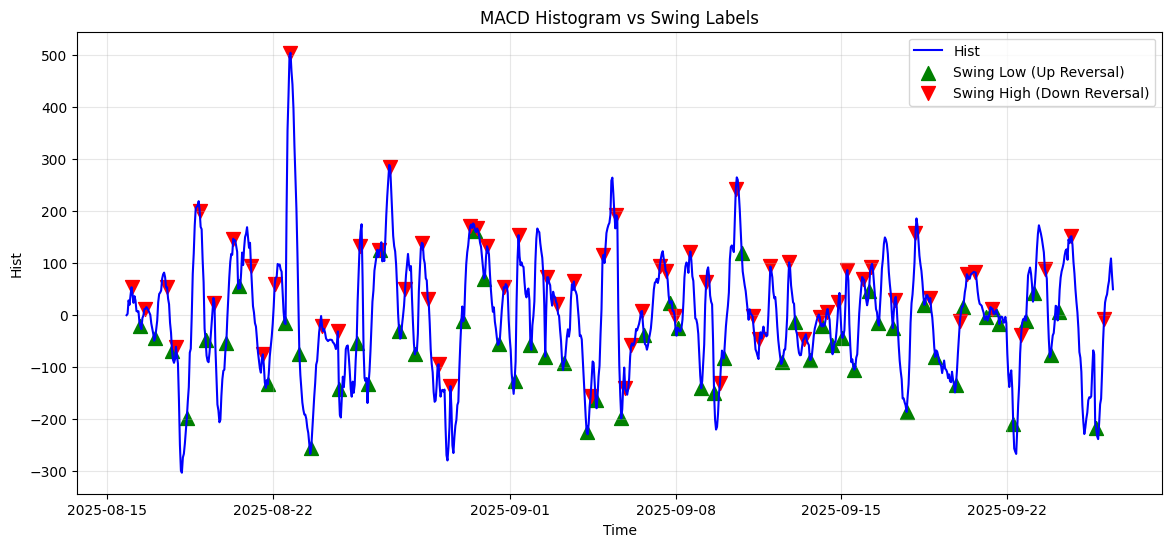

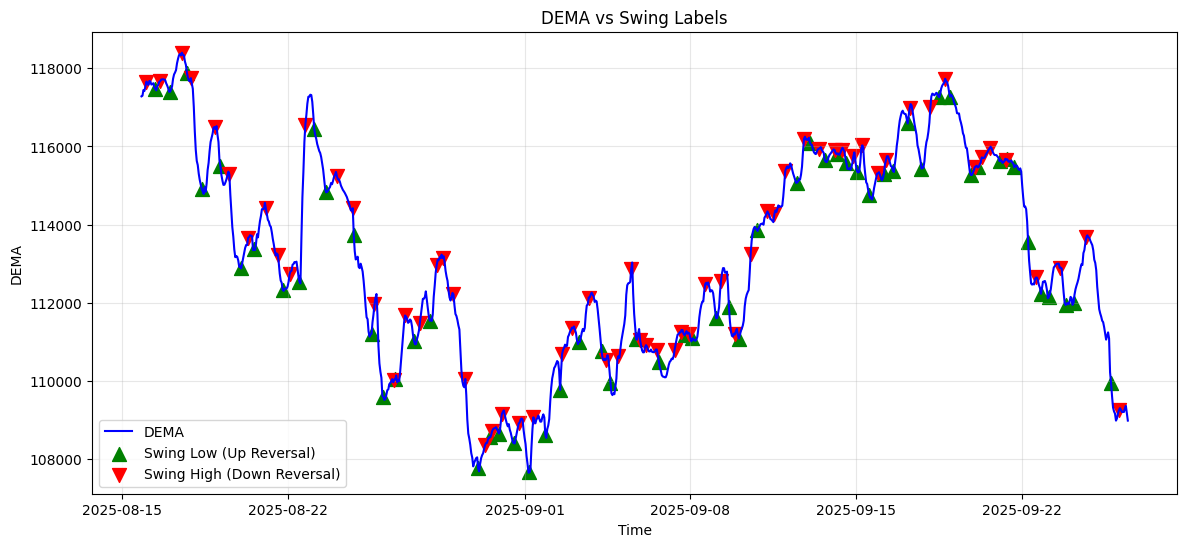

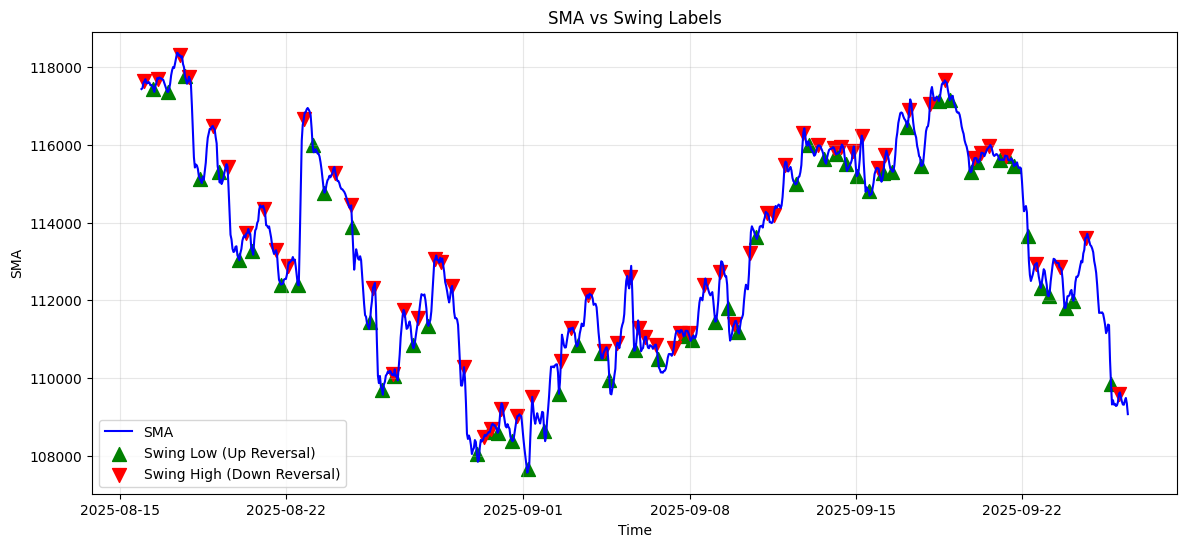

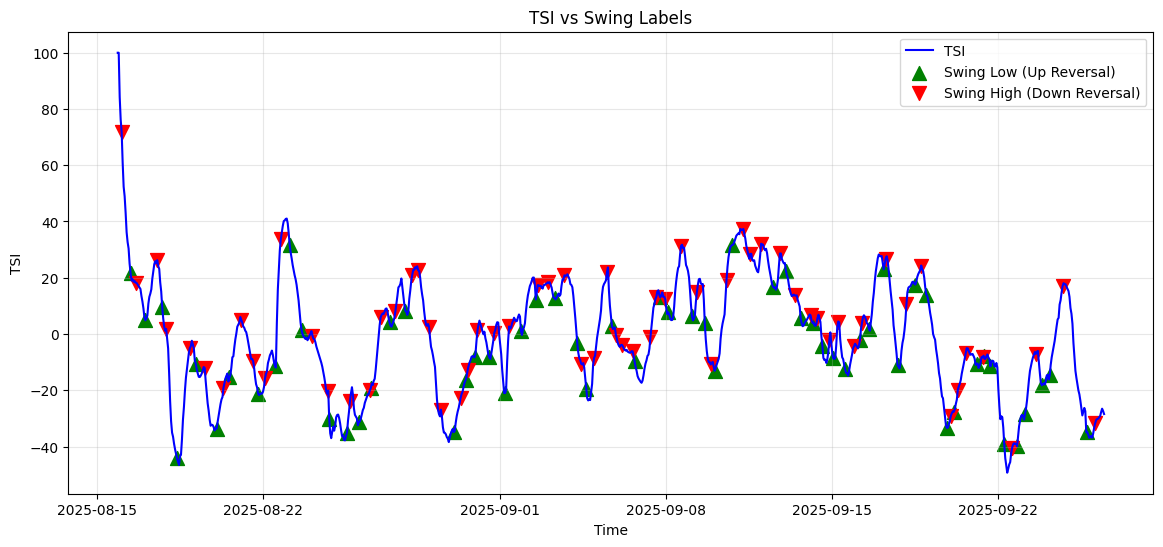

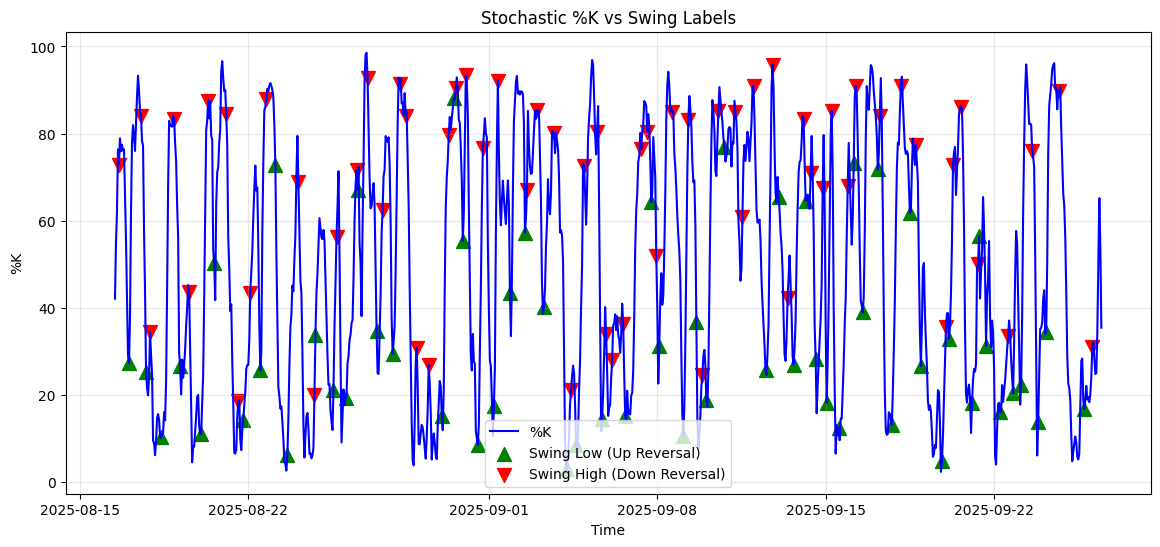

In [9]:
# ============================
# 6. Plot each indicator
# ============================
plot_indicator(df, "RSI", "RSI vs Swing Labels")
plot_indicator(df, "Hist", "MACD Histogram vs Swing Labels")
plot_indicator(df, "DEMA", "DEMA vs Swing Labels")
plot_indicator(df, "SMA", "SMA vs Swing Labels")
plot_indicator(df, "TSI", "TSI vs Swing Labels")
plot_indicator(df, "%K", "Stochastic %K vs Swing Labels")